In [25]:
import os
import numpy as np
import pandas as pd
# Не сворачивать колонки в датафрейме
pd.options.display.max_columns = None
from tqdm import tqdm_notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings('ignore')

In [187]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [188]:
FILE_PATH = '/Users/anton.andreytsev/Empirical-Statistics-EF-MSU-2019/'

### Снижение размерности

Очень часто в анализе данных встречается ситуация, когда объект описан большим числом признаков, но при этом, в этом большимерном пространтсве объекты лежат в какой-то маломерном подпространстве (картинка ниже). Тогда объекты можно описать меньшим числом признаков, главная задача - как выбрать эти признаки и какое должно быть их число, чтобы описание объектов "не сильно пострадало".

На картинке ниже каждый объекты $x_{1}, \dots, x_{n}$ описываются 3 координатами, однако все объекты лежат на плоскости $L = span\{\vec a_{1}, \vec a_{2} \}$ : (p, q, 2p-3q), поэтому для описания этих объектов достаточно знать 2 значения: p и q. С точки зрения линейной алгебры это означает, что мы можем описать наши объекты через базис плоскости L, то есть $x_{i} = \alpha_{1} \cdot \vec a_{1} + \alpha_{2} \cdot \vec a_{2}$ и тогда координатами объекта $x_{i}$ в базисе плоскости L можно назвать $x_{i, L} = (\alpha_{1}, \alpha_{2})$

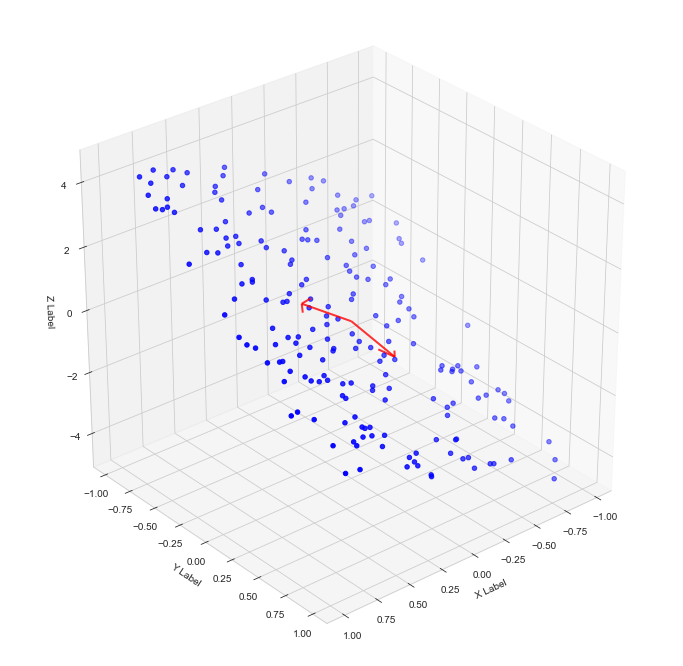

In [345]:
N = 200
x = np.random.uniform(-1, 1, size=N)
y = np.random.uniform(-1, 1, size=N)
z = 2*x - 3*y
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, color='blue')
ax.quiver(0, 0, 0, -0.15595302 - 0, 0.21722557 - 0, -0.96 - 0, color = 'red', alpha = .8, lw = 2, arrow_length_ratio=0.2)
ax.quiver(0, 0, 0, 0.83 - 0, 0.55 - 0, 3 - 0, color = 'red', alpha = .8, lw = 2, arrow_length_ratio=0.1)
ax.view_init(30, 50)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label');

Алгоритм, позволяющий найти это малоразмерное (линейное) описание называется [Метод главных компонент](https://ru.wikipedia.org/wiki/Метод_главных_компонент) (PCA):

1) Центрируем данные $\left( x_{i}' = \frac{x_{i} - mean(x)}{\sigma(x)} \right)$.

2) Находим выборочную ковариационную матрицу $M = \frac{1}{n}X^TX$.

3) Находим её собственные векторы, отвечающие k самым большим по модулю собственным значениям.

Собственные векторы, найденные в пункте 3 это и будут главные компоненты, которые мы ищем.

Рассмотрим PCA на данных c картинки выше

In [332]:
X = np.c_[x, y, 2*x - 3*y]
X_st = (X - X.mean(axis=0))/X.std(axis=0)
M = (1/X_st.shape[0])*X_st.T.dot(X_st)
eigvals, eigvecs = np.linalg.eig(M)
eigvecs = eigvecs[np.argsort(eigvals)[::-1]]
eigvals = np.sort(eigvals)[::-1]

Вектор собственных значений главных компонент

In [337]:
eigvals

array([1.98444539, 1.01555461, 0.        ])

Матрица из главных компонент

In [336]:
eigvecs

array([[-0.7043156 , -0.00646535,  0.70985755],
       [-0.58740338, -0.55619294, -0.58788322],
       [ 0.39861863, -0.83102805,  0.38793759]])

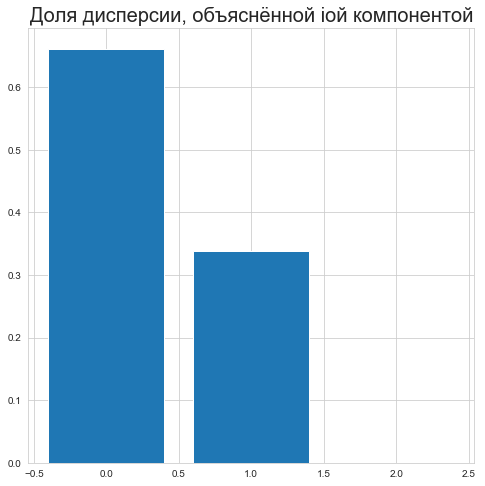

In [338]:
plt.bar(np.arange(3), eigvals/eigvals.sum());
plt.title('Доля дисперсии, объяснённой iой компонентой', fontsize=20);

Полученные главные компоненты всегда ортогональны друг другу (скалярное произведение равно 0). Ввиду этого свойства PCA так же применяют не только для снижения размерности, но и так же для [декорреляции признаков](https://en.wikipedia.org/wiki/Whitening_transformation).

Координаты главной компоненты означают, с какими весами исходные признаки входят в эту главную компоненту. Например comp1 = [-0.71,  -0.59, 0.39] означает, что $comp1 = -0.71 \cdot x - 0.59 \cdot y + 0.39 \cdot z$

При этом встаёт вопрос, как будут описываться иходные объекты через полученные главные компоненты. 

Обозначим исходные (стандартизованные) объекты за $x^{st}_{1}, \dots, x^{st}_{n} \quad x^{st}_{i} \in \mathbb{R}^d$. Обозначим главные компоненты за $u_{1}, \dots, u_{k} \quad u_{j} \in \mathbb{R}^d$ и матрицу из главных компонент за $U = \begin{bmatrix} | & \dots & |\\ u_{1} & \dots & u_{k} \\ | & \dots & | \end{bmatrix}, \ U \in \mathbb{R}^{d \times k}$. Тогда найти координаты исходного объекта $x^{st}_{i}$ в пространстве главных компонент можно по формуле: $x_{i}^{pc} = U^T \cdot x^{st}_{i}, $ где $x_{i}^{pc} \in \mathbb{R}^k$. Чтобы найти координаты всех объектов $X^{st} = \begin{bmatrix} - & x^{st}_{1} & - \\ \vdots & \vdots & \vdots \\ - & x^{st}_{n} & - \end{bmatrix}$ нужно перемножить $X^{st} \cdot U$

In [352]:
X_pc = X_st.dot(eigvecs[:, :2])
X_pc.shape

(200, 2)

Посмотрим на положение конкретного объекта в исходном и в новом пространствах

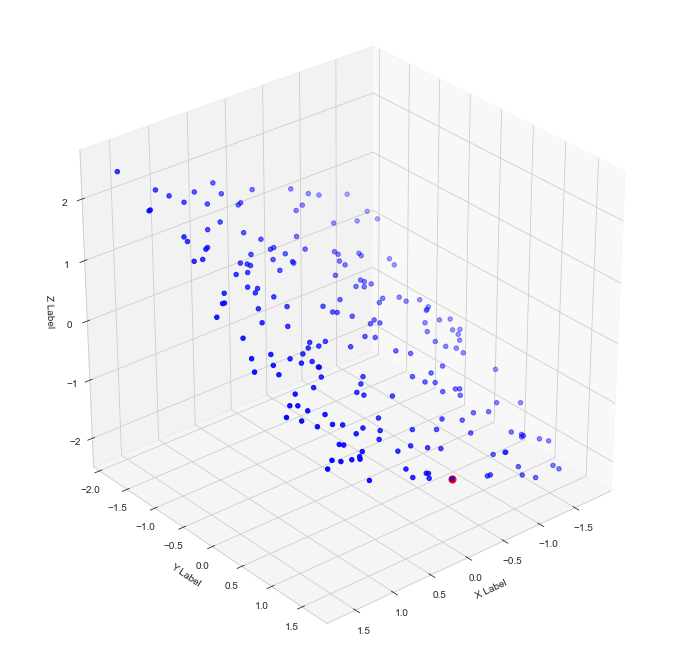

In [356]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_st[:, 0], X_st[:, 1], X_st[:, 2], color='blue')
ax.scatter(X_st[0, 0], X_st[0, 1], X_st[0, 2], color='red', s=50)
ax.view_init(30, 50)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label');

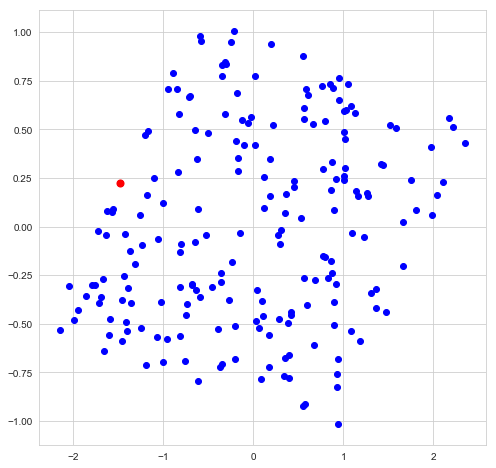

In [357]:
plt.scatter(X_pc[:, 0], X_pc[:, 1], color='blue')
plt.scatter(X_pc[0, 0], X_pc[0, 1], color='red', s=50);

In [13]:
dat = pd.read_csv('/Users/anton.andreytsev/Empirical-Statistics-EF-MSU-2019/data/turkiye-student-evaluation_R_Specific.csv')
dat.columns = [col.replace('.', '_').lower() for col in dat.columns]

In [14]:
dat.head()

,instr,class,nb_repeat,attendance,difficulty,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14,q15,q16,q17,q18,q19,q20,q21,q22,q23,q24,q25,q26,q27,q28
1,1,2,1,0,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
2,1,2,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
3,1,2,1,2,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
4,1,2,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
5,1,2,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
